In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tqdm import tqdm
import os
import sys

from neural_network import NeuralNetwork
from methods import *
from data_gen import Poly1D2Deg, FrankeDataGen, CancerData

np.random.seed(4155) # FYS-STK4155 

In [2]:
# testing (MIA: must be moved)
#!python -m unittest test.py

...........Dataset URL: https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data
/Users/miamerlid/anaconda3/envs/fysstk/lib/python3.12/site-packages/kaggle/api_client.py:165: DeprecationWarning: HTTPResponse.getheaders() is deprecated and will be removed in urllib3 v2.1.0. Instead access HTTPResponse.headers directly.
  response_data.getheaders())
100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 98.50it/s]
.......
----------------------------------------------------------------------
Ran 19 tests in 4.872s

OK


In [3]:
def create_filename(learning_strategy, batch_size, learning_rate):
    return f"../models_Cancer/strat-{learning_strategy}_bs-{batch_size}_lr-{learning_rate}.json"

### Classification

In [4]:
data = CancerData()
inputs = np.array(data.x)
targets = np.array(data.y)

Dataset URL: https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data


In [5]:
input_size = 30
output_size = 1
hidden_layers = [32, 16]
network_shape = [input_size] + hidden_layers + [output_size]
activation_funcs = ["ReLU", "ReLU", "sigmoid"]
cost_fun = "BinaryCrossEntropy"

In [9]:
learning_strats = ["Constant", "Momentum", "Adagrad_Momentum", "Adam", "RMSprop", "Adagrad"]
epochs = 100
learning_rates = [0.1, 0.01, 0.001, 0.0001]
batch_sizes = [32, 64, 128, 256, 512, 1024]

for learning_rate in learning_rates:
    for batch_size in batch_sizes:
        for learning_strat in learning_strats:

            filename = create_filename(learning_strat, batch_size, learning_rate)
            if os.path.exists(filename):
                print(f"Model already exists: {filename}")
                continue

            print(f"Training model: {filename}")
            model = NeuralNetwork(network_shape=network_shape, activation_funcs=activation_funcs, cost_func=cost_fun, type_of_network="classification", update_strategy=learning_strat)
            model.train_network(inputs, targets, epochs=epochs, learning_rate=learning_rate, batch_size=batch_size)
            model.save_network(filename)

            print(f"Model saved: {filename}")

Training model: ../models_Cancer/strat-Constant_bs-32_lr-0.1.json


100%|██████████| 100/100 [00:08<00:00, 11.46it/s]


AttributeError: 'NeuralNetwork' object has no attribute 'save'

In [ ]:
losses = []
accuracies = []
losses_test = []
accuracies_test = []

for learning_strat in tqdm(learning_strats):
    model = NeuralNetwork(network_shape, activation_funcs, cost_fun, "classification", learning_strat, manual_gradients=True)
    _, accuracy_list, loss_list, accuracy_test, loss_test  = model.train_network(inputs, targets, epochs=epochs, learning_rate=learning_rate, batch_size=batch_size)
    losses.append(loss_list)
    accuracies.append(accuracy_list)
    losses_test.append(loss_test)
    accuracies_test.append(accuracy_test)
    file_name = create_filename(learning_strat, batch_size, learning_rate)
    model.save_network(file_name)

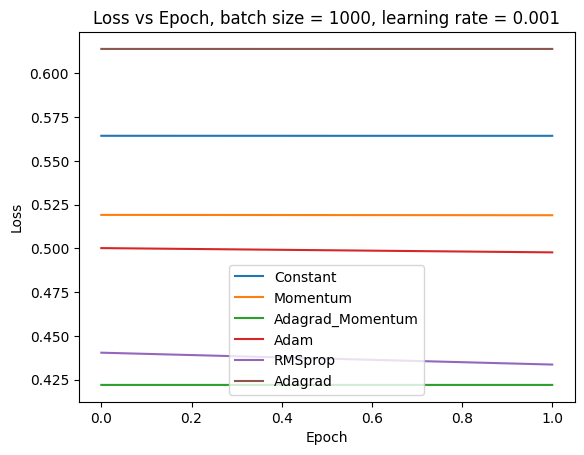

In [7]:
i = 0

for method, loss_list in zip(learning_strats, losses_test):
    if i in [0, 1, 2,3,4,5]:
        plt.plot(loss_list, label=method)
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title(f"Loss vs Epoch, batch size = {batch_size}, learning rate = {learning_rate}")
        plt.legend()
    i += 1
plt.show()

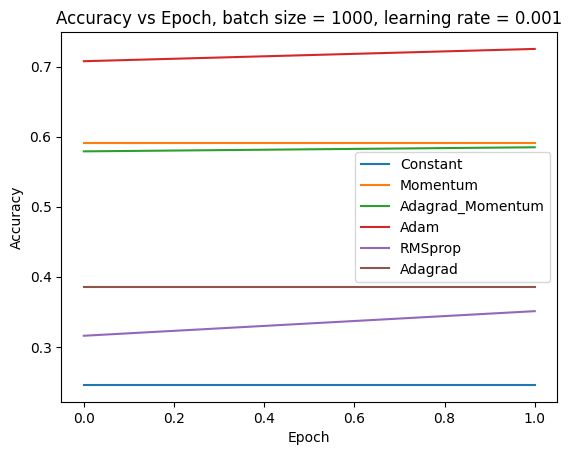

In [8]:
i = 0
for method, accuracy_list in zip(learning_strats, accuracies_test):
    if i in [0, 1, 2,3,4,5]:
        plt.plot(accuracy_list[:], label=method)
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title(f"Accuracy vs Epoch, batch size = {batch_size}, learning rate = {learning_rate}")
        plt.legend()
    i += 1
plt.show()

In [21]:
# load the models and continue training
losses = []
accuracies = []
losses_test = []
accuracies_test = []

for learning_strat in learning_strats:
    file_name = create_filename(learning_strat, batch_size, learning_rate)
    model = NeuralNetwork.load_network(file_name=file_name)
    _, accuracy_list, loss_list, accuracy_test, loss_test  = model.train_network(inputs, targets, epochs=epochs, learning_rate=learning_rate, batch_size=batch_size)
    losses.append(loss_list)
    accuracies.append(accuracy_list)
    losses_test.append(loss_test)
    accuracies_test.append(accuracy_test)
    model.save_network(file_name)

100%|██████████| 2/2 [00:00<00:00, 278.63it/s]


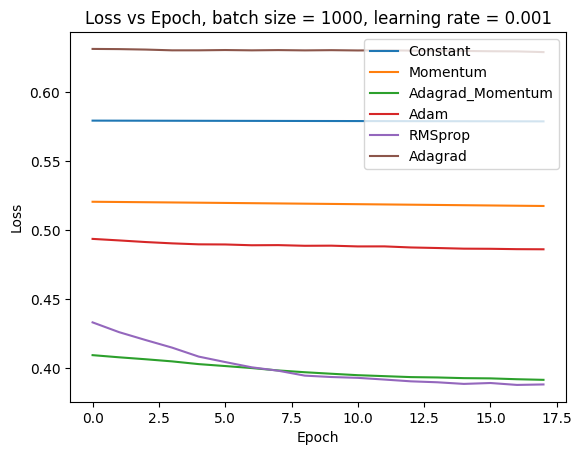

In [22]:
# plot 
i = 0
for method, loss_list in zip(learning_strats, losses):
    if i in [0, 1, 2,3,4,5]:
        plt.plot(loss_list, label=method)
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title(f"Loss vs Epoch, batch size = {batch_size}, learning rate = {learning_rate}")
        plt.legend()
    i += 1
    

In [11]:
# stop running the notebook here
sys.exit()

SystemExit: 

/Users/miamerlid/anaconda3/envs/fysstk/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


### Regression


In [10]:
input_size = 2
output_size = 1
hidden_layers = [32, 16, 8]
network_shape = [input_size] + hidden_layers + [output_size]
activation_funcs = ["sigmoid", "sigmoid", "sigmoid", "identity"]
cost_fun = mse

epochs = 100
learning_rate = 0.001
batch_size = 1000

In [11]:
data = FrankeDataGen(noise=False)
inputs = jnp.column_stack((data.x.flatten(), data.y.flatten()))  
print(len(inputs))
targets = data.z.ravel().reshape(-1, 1)   

10201


In [12]:
learning_strats = ["Constant", "Momentum","Adagrad_Momentum", "Adam", "RMSprop", "Adagrad"]
losses = []
accuracies = []

for learning_strat in tqdm(learning_strats):
    model = NeuralNetwork(network_shape, activation_funcs, cost_fun, "regression", learning_strat, manual_gradients=True)
    _, accuracy_list, loss_list, preds = model.train_network(inputs, targets, epochs=epochs, learning_rate=learning_rate, batch_size=batch_size)
    losses.append(loss_list)
    accuracies.append(accuracy_list)

100%|██████████| 6/6 [00:19<00:00,  3.32s/it]


In [18]:
print(len(losses[0]))

100


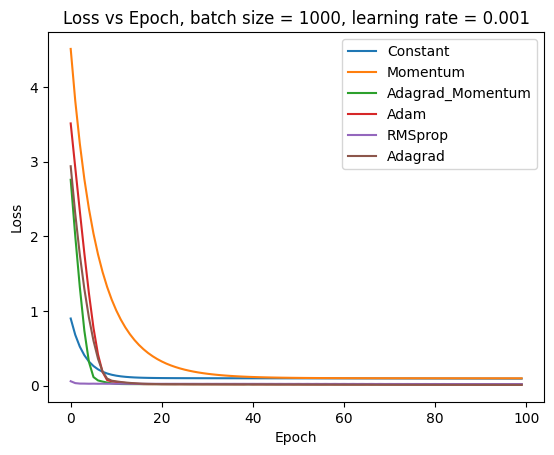

In [19]:
i = 0

for method, loss_list in zip(learning_strats, losses):
    if i in [0, 1, 2,3,4,5]:
        plt.plot(loss_list[:], label=method)
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title(f"Loss vs Epoch, batch size = {batch_size}, learning rate = {learning_rate}")
        plt.legend()
    i += 1
plt.show()

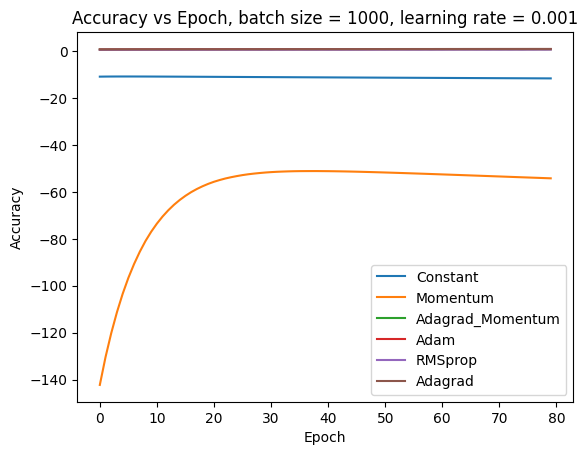

In [22]:
i = 0
for method, accuracy_list in zip(learning_strats, accuracies):
    if i in [0, 1, 2,3,4,5]:
        plt.plot(accuracy_list[20:], label=method)
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title(f"Accuracy vs Epoch, batch size = {batch_size}, learning rate = {learning_rate}")
        plt.legend()
    i += 1
plt.show()